## 目錄

1. **Step 0**：載入套件與全域樣式設定  
2. **Step 1**：資料讀取與前處理  
3. **Step 2**：切分 Train / Val / Test  
4. **Step 3**：標準化 Preprocessor  
5. **Step 4**：偵測少數類並做 SMOTE 增強（輸出 `train_smote.csv`）  
6. **Step 5**：偵測少數類並做 CTGAN 增強（輸出 `train_ctgan.csv`）  
7. **Step 6**：增強品質評估（統計檢驗、MMD、SVCDetection、PCA/t-SNE/UMAP）  
8. **Step 7**：原始/SMOTE/CTGAN 三組資料做 10 種模型訓練與比較（含 baseline）  
   - 訓練九種模型 + **Baseline**  
   - 驗證集量化指標: AUC、F1、Recall、Precision、Accuracy  
   - 繪製 Accuracy 條狀圖比較  
9. **Step 8**：結論與輸出檔案清單  

## Step 0：載入套件與全域樣式設定

以下程式碼段同時：
- 1. 載入所有分析所需套件
- 2. 設定全域隨機種子
- 3. 設定 Seaborn / Matplotlib 全域風格、配色與字體

In [ ]:
import pandas as pd
import numpy as np
import joblib
import random
import os

# 機器學習與增強
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from ctgan import CTGAN

# 統計檢驗
from scipy.stats import ks_2samp, chisquare, entropy

# 增強品質評估
from sdmetrics.single_table import SVCDetection

# 降維
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 分類模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 評估指標
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score

# 固定隨機種子以確保可重現
seed = 42
np.random.seed(seed)
random.seed(seed)

# ======================================
# 全域樣式設定：配色 (Palette)、字體 (Arial)、背景
# ======================================
sns.set_style("white")  # 基礎背景為純白
sns.set_context("notebook", font_scale=1.1)

# 設定字體與顏色
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.edgecolor"] = "#000000"
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["figure.facecolor"] = "#f4f4f4"  # Figure 背景：淡灰
plt.rcParams["axes.facecolor"] = "#ffffff"    # Axes 背景：純白
plt.rcParams["figure.dpi"] = 150               # 解析度
# 自訂調色盤 (主要 #f24300、次要 #ffdfdf)
sns.set_palette(sns.color_palette(["#f24300", "#ffdfdf"]))

print("Step 0: All packages imported and global style set.")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 0: All packages imported and global style set.


## Step 1：讀取原始資料與前處理
 - 讀取 CSV 檔案 (路徑自行確認)
 - 填補遺失值（Age / Stroke Risk (%) / 其餘二元欄位）
 - 移除 “Stroke Risk (%)” 欄位，因為它偏向結果


In [ ]:
print("=== Step 1: 讀取原始資料，缺失值處理 ===")


df_raw = pd.read_csv('/workspace/0_ai_final/data/stroke_risk_dataset.csv')
print("原始資料前 5 筆：")
print(df_raw.head())

# 填補遺失值
df_raw['Age'] = df_raw['Age'].fillna(df_raw['Age'].median())
df_raw['Stroke Risk (%)'] = df_raw['Stroke Risk (%)'].fillna(df_raw['Stroke Risk (%)'].median())
for col in df_raw.columns:
    if col not in ['Age', 'Stroke Risk (%)', 'At Risk (Binary)']:
        df_raw[col] = df_raw[col].fillna(0).astype(int)

# 移除含 “Stroke Risk (%)” 欄位
feature_cols = [
    'Chest Pain', 'Shortness of Breath', 'Irregular Heartbeat',
    'Fatigue & Weakness', 'Dizziness', 'Swelling (Edema)',
    'Pain in Neck/Jaw/Shoulder/Back', 'Excessive Sweating',
    'Persistent Cough', 'Nausea/Vomiting', 'High Blood Pressure',
    'Chest Discomfort (Activity)', 'Cold Hands/Feet', 'Snoring/Sleep Apnea',
    'Anxiety/Feeling of Doom', 'Age'
]
target_col = 'At Risk (Binary)'
df = df_raw[feature_cols + [target_col]].copy()

print(f"處理後資料筆數：{len(df)}")
print("處理後資料欄位：", df.columns.tolist())


=== Step 1: 讀取原始資料，缺失值處理 ===
原始資料前 5 筆：
   Chest Pain  Shortness of Breath  Irregular Heartbeat  Fatigue & Weakness  \
0           0                    1                    1                   1   
1           0                    0                    1                   0   
2           1                    0                    0                   1   
3           1                    0                    1                   1   
4           0                    0                    1                   0   

   Dizziness  Swelling (Edema)  Pain in Neck/Jaw/Shoulder/Back  \
0          0                 0                               0   
1          0                 1                               0   
2          1                 1                               0   
3          0                 1                               1   
4          0                 1                               0   

   Excessive Sweating  Persistent Cough  Nausea/Vomiting  High Blood Pressure  \
0      

## Step 2：切分 Train / Val / Test
 - 先將資料按 80% / 20% 切出 Test
 - 再將剩餘 80% 中以 80/20 切出 Train / Val
 - 同時檢查各集合標籤分佈
 - 將切分結果儲存為 CSV 以備使用


In [ ]:
print("\n=== Step 2: 切分 Train/Val/Test ===")

df_temp, df_test = train_test_split(
    df, test_size=0.2, random_state=seed, stratify=df[target_col]
)
df_train, df_val = train_test_split(
    df_temp, test_size=0.2, random_state=seed, stratify=df_temp[target_col]
)

print(f"切分結果 → Train: {df_train.shape}，Val: {df_val.shape}，Test: {df_test.shape}")
print("Train 標籤分佈：")
print(df_train[target_col].value_counts())
print("Val 標籤分佈：")
print(df_val[target_col].value_counts())
print("Test 標籤分佈：")
print(df_test[target_col].value_counts())

# 輸出 CSV 檔
df_train.to_csv('train.csv', index=False)
df_val.to_csv('val.csv', index=False)
df_test.to_csv('test.csv', index=False)
print("已儲存 train.csv, val.csv, test.csv")



=== Step 2: 切分 Train/Val/Test ===
切分結果 → Train: (44800, 17)，Val: (11200, 17)，Test: (14000, 17)
Train 標籤分佈：
At Risk (Binary)
1    29084
0    15716
Name: count, dtype: int64
Val 標籤分佈：
At Risk (Binary)
1    7271
0    3929
Name: count, dtype: int64
Test 標籤分佈：
At Risk (Binary)
1    9089
0    4911
Name: count, dtype: int64
已儲存 train.csv, val.csv, test.csv


## Step 3：標準化 Preprocessor (僅標準化 Age) 並儲存
 - 建立 ColumnTransformer，只對 Age 做 StandardScaler
 - Fit 在 Train set，再序列化儲存為 `preprocessor.pkl`
 - 後續可以重複使用此 scaler 做預測


In [ ]:
print("\n=== Step 3: 標準化 Preprocessor ===")

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), ['Age'])],
    remainder='passthrough'
)

X_train_orig = df_train.drop(target_col, axis=1)
preprocessor.fit(X_train_orig)
joblib.dump(preprocessor, 'preprocessor.pkl')
print("已儲存標準化模型 preprocessor.pkl")

# 另外取出 Age scaler 方便後續反標準化
age_scaler = preprocessor.named_transformers_['num']



=== Step 3: 標準化 Preprocessor ===
已儲存標準化模型 preprocessor.pkl


## Step 4：自動偵測少數類標籤 & SMOTE 增強
 - 自動偵測 Train 集中哪個 label 是少數 (count 較少)
 - 使用 SMOTE(sampling_strategy=1.0) 使少數類升到與多數同數
 - 反標準化 Age，將其他二元欄位還原為整數
 - 輸出增強後訓練集為 `train_smote.csv`


In [ ]:
print("\n=== Step 4: 自動偵測少數類標籤 & SMOTE 增強 ===")

# 4.1 自動偵測少數／多數 label
label_counts = df_train[target_col].value_counts()
minority_label = int(label_counts.idxmin())
majority_label = int(label_counts.idxmax())
count_minor = int(label_counts.min())
count_major = int(label_counts.max())
print(f"自動偵測：少數類標籤 = {minority_label}，多數類標籤 = {majority_label}")
print(f"少數類樣本數 = {count_minor}，多數類樣本數 = {count_major}")

# 4.2 準備 SMOTE
X_train_feat = df_train.drop(target_col, axis=1)
y_train = df_train[target_col]
X_train_scaled = preprocessor.transform(X_train_feat)

smote = SMOTE(sampling_strategy=1.0, random_state=seed, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
print("SMOTE 增強後各類別分佈：")
print(pd.Series(y_smote).value_counts())

# 4.3 反標準化 Age，將其餘欄位還原並轉整數
df_smote = pd.DataFrame(X_smote, columns=X_train_feat.columns)
df_smote['Age'] = age_scaler.inverse_transform(df_smote[['Age']])
for col in feature_cols:
    if col != 'Age':
        df_smote[col] = df_smote[col].round().astype(int)
df_smote[target_col] = y_smote.values

# 4.4 輸出 CSV
df_smote.to_csv('train_smote.csv', index=False)
print("已儲存 SMOTE 增強訓練集：train_smote.csv")



=== Step 4: 自動偵測少數類標籤 & SMOTE 增強 ===
自動偵測：少數類標籤 = 0，多數類標籤 = 1
少數類樣本數 = 15716，多數類樣本數 = 29084


SMOTE 增強後各類別分佈：
At Risk (Binary)
1    29084
0    29084
Name: count, dtype: int64
已儲存 SMOTE 增強訓練集：train_smote.csv


## Step 5：自動偵測少數類標籤 & CTGAN 增強
 - 再次檢查少數／多數 label 以確保一致
 - 篩出少數類原始樣本 (df_minority)，做 CTGAN fit
 - 用 batch sampling 方式，不斷抽樣，直到得到所需數量的少數標籤合成樣本
 - 反標準化 Age，二元欄位轉整數，組成 `train_ctgan.csv`


In [ ]:
print("\n=== Step 5: 自動偵測少數類標籤 & CTGAN 增強 ===")

# 5.1 再次確認純原始 df_train 標籤數量
X_train_orig = df_train.drop(target_col, axis=1)
y_train_orig = df_train[target_col]
label_counts_orig = y_train_orig.value_counts()
minority_label = int(label_counts_orig.idxmin())
majority_label = int(label_counts_orig.idxmax())
count_minor = int(label_counts_orig.min())
count_major = int(label_counts_orig.max())
print(f"再次確認：少數類標籤 = {minority_label}，多數類標籤 = {majority_label}")
print(f"原始少數類樣本數 = {count_minor}，原始多數類樣本數 = {count_major}")

# 5.2 篩出少數類 (for CTGAN training)
minority = X_train_orig[y_train_orig == minority_label]
minority_scaled = preprocessor.transform(minority)
df_minority = pd.DataFrame(minority_scaled, columns=X_train_orig.columns)
df_minority[target_col] = minority_label  # 少數類標籤

# 5.3 計算需合成數量 (原始多數 - 原始少數)
n_to_gen = count_major - count_minor
print(f"需合成數量 = {n_to_gen} 條\n")

# 5.4 初始化 CTGAN，pac=1 避免 sample 出錯
ctgan = CTGAN(
    epochs=300,
    batch_size=256,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    verbose=True,
    pac=1
)

# 5.5 訓練 CTGAN：只給少數類 & 指定離散欄位 (15 個二元 + 標籤)
ctgan.fit(
    df_minority,
    discrete_columns=[col for col in feature_cols if col != 'Age'] + [target_col]
)

# 5.6 正式抽樣：不斷抽 batch 大小，篩選少數類
print("產生合成資料中...（無條件 sample，再保留少數類）")
df_synth = pd.DataFrame(columns=df_minority.columns)
batch_size = min(100, n_to_gen)

while len(df_synth) < n_to_gen:
    temp_all = ctgan.sample(batch_size)
    temp_min = temp_all[temp_all[target_col] == minority_label].copy()
    if temp_min.shape[0] == 0:
        continue
    df_synth = pd.concat([df_synth, temp_min], ignore_index=True)
    print(f"目前累積合成少數: {len(df_synth)} / {n_to_gen}")

# 5.7 僅保留前 n_to_gen 筆
df_synth = df_synth.iloc[:n_to_gen].copy()

# 5.8 反標準化 Age，二元欄位四捨五入並轉 int
df_synth['Age'] = age_scaler.inverse_transform(df_synth[['Age']])
for col in feature_cols:
    if col != 'Age':
        df_synth[col] = df_synth[col].round().astype(int)
df_synth[target_col] = minority_label

# 5.9 合併 df_train + df_synth → 輸出 CSV
df_ctgan = pd.concat([df_train, df_synth], ignore_index=True)
print("CTGAN 增強後資料筆數：", df_ctgan.shape)
print("CTGAN 增強後各類別分布：")
print(df_ctgan[target_col].value_counts())

df_ctgan.to_csv('train_ctgan.csv', index=False)
print("已儲存 CTGAN 增強訓練集：train_ctgan.csv")



=== Step 5: 自動偵測少數類標籤 & CTGAN 增強 ===
再次確認：少數類標籤 = 0，多數類標籤 = 1
原始少數類樣本數 = 15716，原始多數類樣本數 = 29084
需合成數量 = 13368 條



Gen. (-0.24) | Discrim. (-0.09): 100%|██████████| 300/300 [07:12<00:00,  1.44s/it]
/tmp/ipykernel_1681016/4133525832.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_synth = pd.concat([df_synth, temp_min], ignore_index=True)


產生合成資料中...（無條件 sample，再保留少數類）
目前累積合成少數: 100 / 13368
目前累積合成少數: 200 / 13368
目前累積合成少數: 300 / 13368
目前累積合成少數: 400 / 13368
目前累積合成少數: 500 / 13368
目前累積合成少數: 600 / 13368
目前累積合成少數: 700 / 13368
目前累積合成少數: 800 / 13368
目前累積合成少數: 900 / 13368
目前累積合成少數: 1000 / 13368
目前累積合成少數: 1100 / 13368
目前累積合成少數: 1200 / 13368
目前累積合成少數: 1300 / 13368
目前累積合成少數: 1400 / 13368
目前累積合成少數: 1500 / 13368
目前累積合成少數: 1600 / 13368
目前累積合成少數: 1700 / 13368
目前累積合成少數: 1800 / 13368
目前累積合成少數: 1900 / 13368
目前累積合成少數: 2000 / 13368
目前累積合成少數: 2100 / 13368
目前累積合成少數: 2200 / 13368
目前累積合成少數: 2300 / 13368
目前累積合成少數: 2400 / 13368
目前累積合成少數: 2500 / 13368
目前累積合成少數: 2600 / 13368
目前累積合成少數: 2700 / 13368
目前累積合成少數: 2800 / 13368
目前累積合成少數: 2900 / 13368
目前累積合成少數: 3000 / 13368
目前累積合成少數: 3100 / 13368
目前累積合成少數: 3200 / 13368
目前累積合成少數: 3300 / 13368
目前累積合成少數: 3400 / 13368
目前累積合成少數: 3500 / 13368
目前累積合成少數: 3600 / 13368
目前累積合成少數: 3700 / 13368
目前累積合成少數: 3800 / 13368
目前累積合成少數: 3900 / 13368
目前累積合成少數: 4000 / 13368
目前累積合成少數: 4100 / 13368
目前累積合成少數: 4200 / 13368
目前累積合成少數: 430


=== Step 6: 增強資料品質評估 ===

--- 單欄位統計檢驗 ---
SMOTE Age K–S: stat=0.872, p=0.000
CTGAN Age K–S: stat=0.872, p=0.000
Chest Pain                          卡方 → SMOTE stat=2142.350, p=0.000 | CTGAN stat=1088.860, p=0.000
Shortness of Breath                 卡方 → SMOTE stat=2.507, p=0.113 | CTGAN stat=28.000, p=0.000
Irregular Heartbeat                 卡方 → SMOTE stat=13.945, p=0.000 | CTGAN stat=42.279, p=0.000
Fatigue & Weakness                  卡方 → SMOTE stat=2.071, p=0.150 | CTGAN stat=17.185, p=0.000
Dizziness                           卡方 → SMOTE stat=0.720, p=0.396 | CTGAN stat=0.051, p=0.821
Swelling (Edema)                    卡方 → SMOTE stat=10.087, p=0.001 | CTGAN stat=441.034, p=0.000
Pain in Neck/Jaw/Shoulder/Back      卡方 → SMOTE stat=1.013, p=0.314 | CTGAN stat=125.914, p=0.000
Excessive Sweating                  卡方 → SMOTE stat=1.534, p=0.215 | CTGAN stat=6.495, p=0.011
Persistent Cough                    卡方 → SMOTE stat=0.687, p=0.407 | CTGAN stat=196.633, p=0.000
Nausea/Vomiting

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

SVCDetection AUC → SMOTE: 0.067, CTGAN: 0.036

--- 可視化 PCA / t-SNE / UMAP ---


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

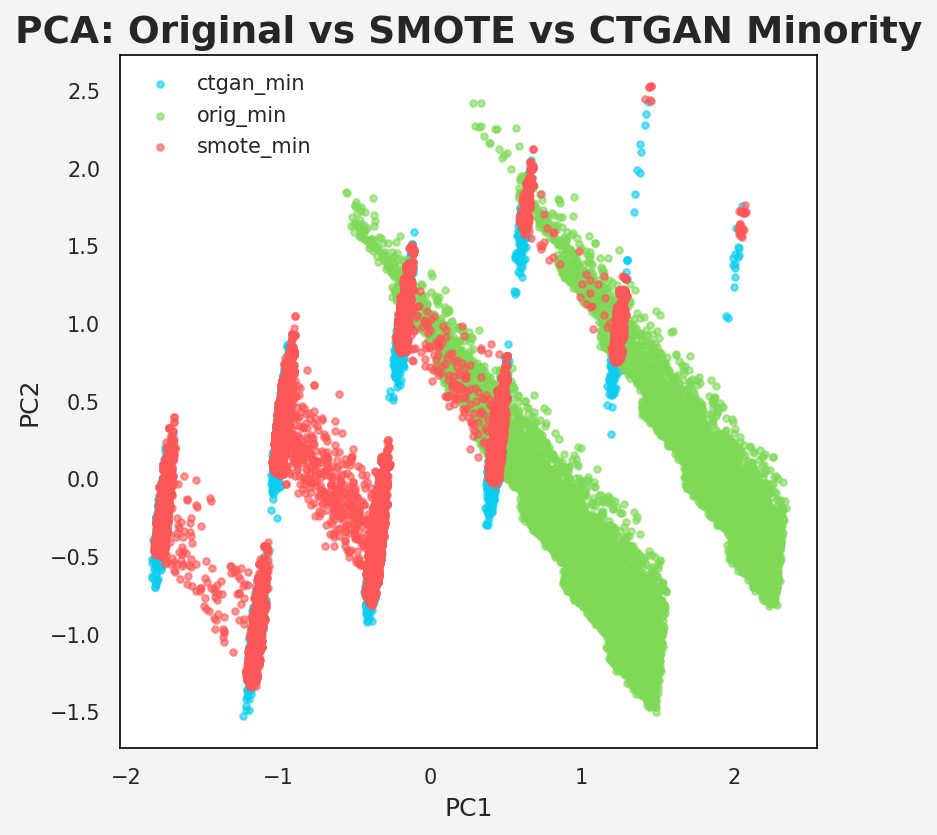

In [ ]:
print("\n=== Step 6: 增強資料品質評估 ===")


# 6.1 自訂 MMD (RBF Kernel 版本)
def rbf_kernel(X, Y, sigma=1.0):
    XX = np.sum(X ** 2, axis=1)[:, None]
    YY = np.sum(Y ** 2, axis=1)[None, :]
    distances = XX + YY - 2 * X.dot(Y.T)
    return np.exp(-distances / (2 * sigma ** 2))


def mmd_rbf(X, Y, sigma=1.0):
    n = X.shape[0];
    m = Y.shape[0]
    Kxx = rbf_kernel(X, X, sigma)
    Kyy = rbf_kernel(Y, Y, sigma)
    Kxy = rbf_kernel(X, Y, sigma)
    sum_Kxx = (np.sum(Kxx) - np.trace(Kxx)) / (n * (n - 1))
    sum_Kyy = (np.sum(Kyy) - np.trace(Kyy)) / (m * (m - 1))
    sum_Kxy = np.sum(Kxy) / (n * m)
    return sum_Kxx + sum_Kyy - 2 * sum_Kxy


# 6.2 準備三組少數類資料 (原始、SMOTE 、CTGAN)
orig_min = df_train[df_train[target_col] == minority_label]
synth_smote_min = df_smote[df_smote[target_col] == minority_label]
synth_ctgan_min = df_ctgan[df_ctgan[target_col] == minority_label].iloc[count_minor:]

# 6.3 單欄位統計檢驗 (K–S、卡方、KL/JS)
print("\n--- 單欄位統計檢驗 ---")
# Age K–S
ks_s, p_s = ks_2samp(orig_min['Age'], synth_smote_min['Age'])
print(f"SMOTE Age K–S: stat={ks_s:.3f}, p={p_s:.3f}")
ks_c, p_c = ks_2samp(orig_min['Age'], synth_ctgan_min['Age'])
print(f"CTGAN Age K–S: stat={ks_c:.3f}, p={p_c:.3f}")

# 二元欄位卡方 (調整期望頻次，使 sum 一致)
for col in feature_cols:
    if col == 'Age':
        continue
    orig_counts = orig_min[col].value_counts().reindex([0, 1], fill_value=0).values.astype(float)
    sm_counts = synth_smote_min[col].value_counts().reindex([0, 1], fill_value=0).values.astype(float)
    ct_counts = synth_ctgan_min[col].value_counts().reindex([0, 1], fill_value=0).values.astype(float)

    sum_orig = orig_counts.sum()
    sum_sm = sm_counts.sum()
    sum_ct = ct_counts.sum()

    if sum_orig > 0:
        exp_sm = orig_counts * (sum_sm / sum_orig)
        exp_ct = orig_counts * (sum_ct / sum_orig)
    else:
        exp_sm = np.ones_like(orig_counts) * (sum_sm / len(orig_counts))
        exp_ct = np.ones_like(orig_counts) * (sum_ct / len(orig_counts))

    stat_sm, p_sm = chisquare(f_obs=sm_counts, f_exp=exp_sm)
    stat_ct, p_ct = chisquare(f_obs=ct_counts, f_exp=exp_ct)
    print(f"{col:<35} 卡方 → SMOTE stat={stat_sm:.3f}, p={p_sm:.3f} | CTGAN stat={stat_ct:.3f}, p={p_ct:.3f}")

# Age KL / JS
bins = np.linspace(df_train['Age'].min(), df_train['Age'].max(), 20)
h_orig, _ = np.histogram(orig_min['Age'], bins=bins, density=True)
h_sm, _ = np.histogram(synth_smote_min['Age'], bins=bins, density=True)
h_ct, _ = np.histogram(synth_ctgan_min['Age'], bins=bins, density=True)
h_orig += 1e-8;
h_sm += 1e-8;
h_ct += 1e-8

kl_sm = entropy(h_orig, qk=h_sm);
kl_ct = entropy(h_orig, qk=h_ct)
m1 = 0.5 * (h_orig + h_sm);
m2 = 0.5 * (h_orig + h_ct)
js_sm = 0.5 * (entropy(h_orig, qk=m1) + entropy(h_sm, qk=m1))
js_ct = 0.5 * (entropy(h_orig, qk=m2) + entropy(h_ct, qk=m2))
print(f"Age KL → SMOTE: {kl_sm:.3f}, CTGAN: {kl_ct:.3f}")
print(f"Age JS → SMOTE: {js_sm:.3f}, CTGAN: {js_ct:.3f}")

# 6.4 多維度一致性：MMD & SVCDetection
print("\n--- 多維度一致性指標 ---")
X_orig_min = preprocessor.transform(orig_min.drop(target_col, axis=1))
X_sm_min = preprocessor.transform(synth_smote_min.drop(target_col, axis=1))
X_ct_min = preprocessor.transform(synth_ctgan_min.drop(target_col, axis=1))

mmd_sm = mmd_rbf(X_orig_min, X_sm_min, sigma=1.0)
mmd_ct = mmd_rbf(X_orig_min, X_ct_min, sigma=1.0)
print(f"MMD (SMOTE vs 原始少數): {mmd_sm:.3f}")
print(f"MMD (CTGAN vs 原始少數): {mmd_ct:.3f}")

res_sm = SVCDetection.compute(orig_min, synth_smote_min)
auc_sm = res_sm['auc'] if isinstance(res_sm, dict) and 'auc' in res_sm else float(res_sm)
res_ct = SVCDetection.compute(orig_min, synth_ctgan_min)
auc_ct = res_ct['auc'] if isinstance(res_ct, dict) and 'auc' in res_ct else float(res_ct)
print(f"SVCDetection AUC → SMOTE: {auc_sm:.3f}, CTGAN: {auc_ct:.3f}")

# 6.5 可視化：PCA / t-SNE / UMAP
print("\n--- 可視化 PCA / t-SNE / UMAP ---")
X_comb = np.vstack([X_orig_min, X_sm_min, X_ct_min])
labels = ['orig_min'] * len(X_orig_min) + ['smote_min'] * len(X_sm_min) + ['ctgan_min'] * len(X_ct_min)
color_map = {'orig_min': '#7ed957', 'smote_min': '#ff5757', 'ctgan_min': '#0ccdf0'}

# PCA
pca_emb = PCA(n_components=2).fit_transform(X_comb)
plt.figure(figsize=(6, 6))
for lbl in np.unique(labels):
    idx = np.array(labels) == lbl
    plt.scatter(pca_emb[idx, 0], pca_emb[idx, 1], s=10, c=color_map[lbl], label=lbl, alpha=0.6)
plt.legend(frameon=False, fontsize=10)
plt.title("PCA: Original vs SMOTE vs CTGAN Minority")
plt.xlabel("PC1");
plt.ylabel("PC2")
plt.grid(False)
plt.savefig('pca_all.png')
plt.show()
plt.close()




findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

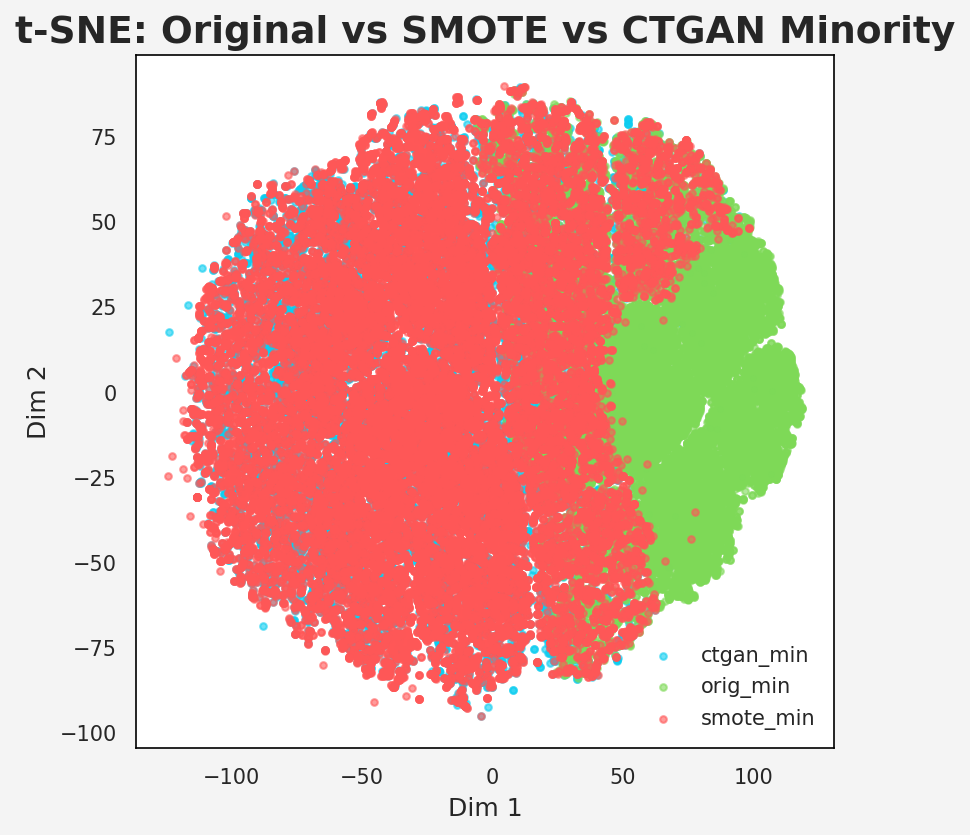

In [ ]:
# t-SNE
tsne_emb = TSNE(n_components=2, perplexity=30, random_state=seed).fit_transform(X_comb)
plt.figure(figsize=(6, 6))
for lbl in np.unique(labels):
    idx = np.array(labels) == lbl
    plt.scatter(tsne_emb[idx, 0], tsne_emb[idx, 1], s=10, c=color_map[lbl], label=lbl, alpha=0.6)
plt.legend(frameon=False, fontsize=10)
plt.title("t-SNE: Original vs SMOTE vs CTGAN Minority")
plt.xlabel("Dim 1");
plt.ylabel("Dim 2")
plt.grid(False)
plt.savefig('tsne_all.png')
plt.show()
plt.close()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

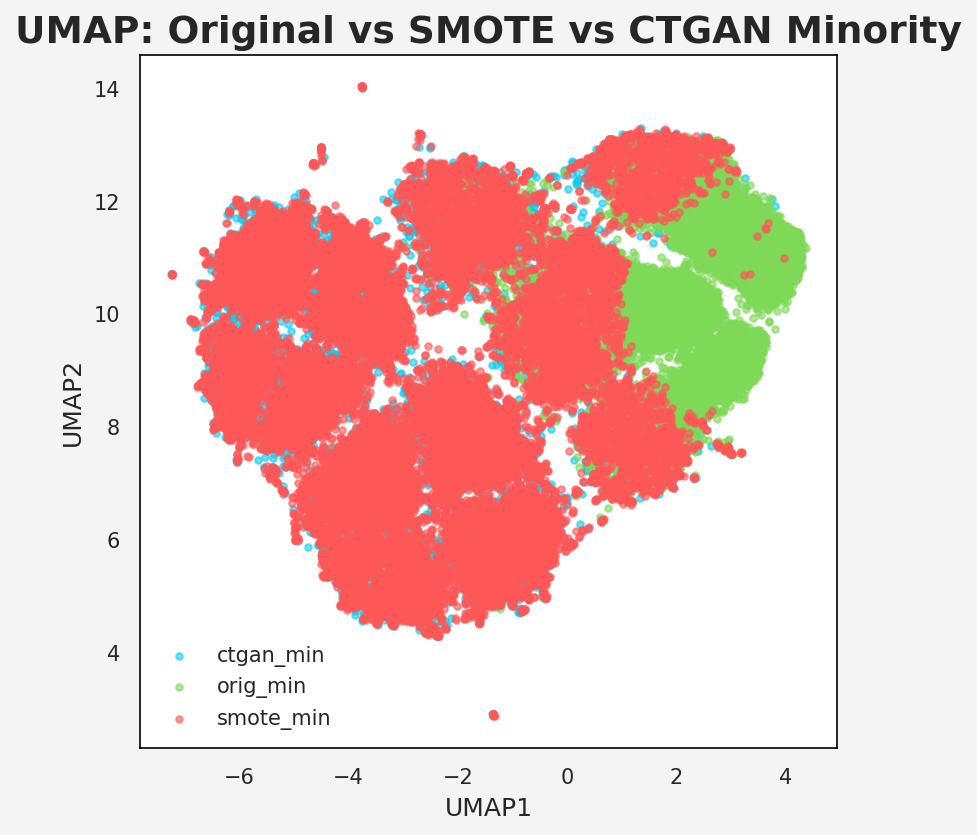

已儲存：pca_all.png, tsne_all.png, umap_all.png


In [ ]:
# UMAP
reducer = UMAP(n_neighbors=20, min_dist=0.1, random_state=seed)
umap_emb = reducer.fit_transform(X_comb)
plt.figure(figsize=(6, 6))
for lbl in np.unique(labels):
    idx = np.array(labels) == lbl
    plt.scatter(umap_emb[idx, 0], umap_emb[idx, 1], s=10, c=color_map[lbl], label=lbl, alpha=0.6)
plt.legend(frameon=False, fontsize=10)
plt.title("UMAP: Original vs SMOTE vs CTGAN Minority")
plt.xlabel("UMAP1");
plt.ylabel("UMAP2")
plt.grid(False)
plt.savefig('umap_all.png')
plt.show()
plt.close()

print("已儲存：pca_all.png, tsne_all.png, umap_all.png")


## Step 7：三組資料 (Original / SMOTE / CTGAN) 模型訓練與比較
1. **Baseline**：原始訓練集 (不做增強)  
2. 在 **SMOTE** 訓練集上訓練  
3. 在 **CTGAN** 訓練集上訓練  

各組都使用以下 10 種模型：  
- **LogisticRegression**  
- **KNeighborsClassifier** (k=5 預設)  
- **GaussianNB**  
- **BernoulliNB**  
- **DecisionTreeClassifier**  
- **RandomForestClassifier**  
- **XGBClassifier**  
- **SVC (linear)**  
- **SVC (rbf)**  
- **BaselineDummy**：DummyClassifier (簡單多數類預測，用於基準)  

衡量指標：  
- AUC  
- F1  
- Recall  
- Precision  
- **Accuracy** (特別加入 Accuracy 圖表比較)


In [ ]:
print("\n=== Step 7: 三組資料模型訓練與比較 ===")

# 7.1 載入驗證集並標準化
X_val = df_val.drop(target_col, axis=1)
y_val = df_val[target_col]
X_val_scaled = preprocessor.transform(X_val)

# 7.2 定義模型
from sklearn.dummy import DummyClassifier

model_dict = {
    'BaselineMajority': DummyClassifier(strategy="most_frequent", random_state=seed),
    'LogisticRegression': LogisticRegression(random_state=seed, max_iter=1000),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed),
    'SVC_linear': SVC(kernel='linear', probability=True, random_state=seed),
    'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=seed)
}


# 7.3 定義訓練並評估函式
def train_and_evaluate(df_train_set, prefix):
    """
    對傳入的 df_train_set（含 target_col）訓練所有模型，
    並在 df_val 上評估 AUC, F1, Recall, Precision, Accuracy。
    回傳結果 list-of-dict。
    """
    X_train_set = df_train_set.drop(target_col, axis=1)
    y_train_set = df_train_set[target_col]
    X_train_scaled = preprocessor.transform(X_train_set)

    results = []
    for name, model in model_dict.items():
        print(f"\n訓練 {name} on {prefix} dataset")
        model.fit(X_train_scaled, y_train_set)
        y_pred = model.predict(X_val_scaled)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_val_scaled)[:, 1]
        else:
            y_proba = y_pred  # DummyClassifier 或無 predict_proba 的模型

        auc = roc_auc_score(y_val, y_proba)
        f1 = f1_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)

        print(f"Val AUC={auc:.3f}, F1={f1:.3f}, Recall={recall:.3f}, Precision={precision:.3f}, Acc={acc:.3f}")
        # 儲存模型
        model_fn = f"{name}_{prefix}_model.pkl"
        joblib.dump(model, model_fn)
        print(f"Model saved: {model_fn}")

        results.append({
            'Model': name,
            'Dataset': prefix,
            'Val_AUC': auc,
            'Val_F1': f1,
            'Val_Recall': recall,
            'Val_Precision': precision,
            'Val_Accuracy': acc,
            'filename': model_fn
        })
    return results



=== Step 7: 三組資料模型訓練與比較 ===


In [ ]:
# 7.4 建立 Original Baseline 結果 (不做增強)
print("\n--- Baseline (Original) Training ---")
results_orig = train_and_evaluate(df_train, 'original')


--- Baseline (Original) Training ---

訓練 BaselineMajority on original dataset
Val AUC=0.500, F1=0.787, Recall=1.000, Precision=0.649, Acc=0.649
Model saved: BaselineMajority_original_model.pkl

訓練 LogisticRegression on original dataset
Val AUC=1.000, F1=1.000, Recall=1.000, Precision=1.000, Acc=1.000
Model saved: LogisticRegression_original_model.pkl

訓練 KNeighbors on original dataset
Val AUC=0.970, F1=0.930, Recall=0.940, Precision=0.921, Acc=0.909
Model saved: KNeighbors_original_model.pkl

訓練 GaussianNB on original dataset
Val AUC=0.978, F1=0.944, Recall=0.955, Precision=0.934, Acc=0.927
Model saved: GaussianNB_original_model.pkl

訓練 BernoulliNB on original dataset
Val AUC=0.952, F1=0.903, Recall=0.938, Precision=0.870, Acc=0.869
Model saved: BernoulliNB_original_model.pkl

訓練 DecisionTree on original dataset
Val AUC=0.870, F1=0.908, Recall=0.906, Precision=0.910, Acc=0.881
Model saved: DecisionTree_original_model.pkl

訓練 RandomForest on original dataset
Val AUC=0.992, F1=0.961, Re

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:158: UserWarning: [06:25:43] WARNING: /home/coder/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Val AUC=1.000, F1=0.998, Recall=0.998, Precision=0.997, Acc=0.997
Model saved: XGBoost_original_model.pkl

訓練 SVC_linear on original dataset
Val AUC=1.000, F1=1.000, Recall=1.000, Precision=1.000, Acc=1.000
Model saved: SVC_linear_original_model.pkl

訓練 SVC_rbf on original dataset
Val AUC=1.000, F1=0.995, Recall=0.996, Precision=0.993, Acc=0.993
Model saved: SVC_rbf_original_model.pkl


In [ ]:
# 7.5 SMOTE 訓練集
print("\n--- SMOTE Training ---")
results_smote = train_and_evaluate(df_smote, 'smote')


--- SMOTE Training ---

訓練 BaselineMajority on smote dataset
Val AUC=0.500, F1=0.000, Recall=0.000, Precision=0.000, Acc=0.351
Model saved: BaselineMajority_smote_model.pkl

訓練 LogisticRegression on smote dataset


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val AUC=0.943, F1=0.895, Recall=0.948, Precision=0.847, Acc=0.855
Model saved: LogisticRegression_smote_model.pkl

訓練 KNeighbors on smote dataset
Val AUC=0.781, F1=0.830, Recall=0.938, Precision=0.744, Acc=0.750
Model saved: KNeighbors_smote_model.pkl

訓練 GaussianNB on smote dataset
Val AUC=0.839, F1=0.851, Recall=0.942, Precision=0.777, Acc=0.786
Model saved: GaussianNB_smote_model.pkl

訓練 BernoulliNB on smote dataset
Val AUC=0.760, F1=0.771, Recall=0.774, Precision=0.769, Acc=0.702
Model saved: BernoulliNB_smote_model.pkl

訓練 DecisionTree on smote dataset
Val AUC=0.665, F1=0.818, Recall=0.908, Precision=0.743, Acc=0.737
Model saved: DecisionTree_smote_model.pkl

訓練 RandomForest on smote dataset
Val AUC=0.736, F1=0.822, Recall=0.926, Precision=0.740, Acc=0.740
Model saved: RandomForest_smote_model.pkl

訓練 XGBoost on smote dataset


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:158: UserWarning: [06:26:15] WARNING: /home/coder/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Val AUC=0.777, F1=0.800, Recall=0.865, Precision=0.745, Acc=0.720
Model saved: XGBoost_smote_model.pkl

訓練 SVC_linear on smote dataset


Val AUC=0.939, F1=0.890, Recall=0.952, Precision=0.836, Acc=0.847
Model saved: SVC_linear_smote_model.pkl

訓練 SVC_rbf on smote dataset
Val AUC=0.917, F1=0.847, Recall=0.954, Precision=0.762, Acc=0.777
Model saved: SVC_rbf_smote_model.pkl


In [ ]:
# 7.6 CTGAN 訓練集
print("\n--- CTGAN Training ---")
results_ctgan = train_and_evaluate(df_ctgan, 'ctgan')


--- CTGAN Training ---

訓練 BaselineMajority on ctgan dataset
Val AUC=0.500, F1=0.000, Recall=0.000, Precision=0.000, Acc=0.351
Model saved: BaselineMajority_ctgan_model.pkl

訓練 LogisticRegression on ctgan dataset


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Val AUC=0.989, F1=0.945, Recall=0.920, Precision=0.972, Acc=0.931
Model saved: LogisticRegression_ctgan_model.pkl

訓練 KNeighbors on ctgan dataset
Val AUC=0.960, F1=0.916, Recall=0.901, Precision=0.932, Acc=0.893
Model saved: KNeighbors_ctgan_model.pkl

訓練 GaussianNB on ctgan dataset
Val AUC=0.982, F1=0.941, Recall=0.941, Precision=0.941, Acc=0.923
Model saved: GaussianNB_ctgan_model.pkl

訓練 BernoulliNB on ctgan dataset
Val AUC=0.874, F1=0.824, Recall=0.777, Precision=0.876, Acc=0.784
Model saved: BernoulliNB_ctgan_model.pkl

訓練 DecisionTree on ctgan dataset
Val AUC=0.872, F1=0.908, Recall=0.905, Precision=0.912, Acc=0.882
Model saved: DecisionTree_ctgan_model.pkl

訓練 RandomForest on ctgan dataset
Val AUC=0.991, F1=0.962, Recall=0.961, Precision=0.963, Acc=0.951
Model saved: RandomForest_ctgan_model.pkl

訓練 XGBoost on ctgan dataset


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:158: UserWarning: [06:28:50] WARNING: /home/coder/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Val AUC=1.000, F1=0.997, Recall=0.997, Precision=0.996, Acc=0.996
Model saved: XGBoost_ctgan_model.pkl

訓練 SVC_linear on ctgan dataset


Val AUC=0.992, F1=0.954, Recall=0.934, Precision=0.975, Acc=0.942
Model saved: SVC_linear_ctgan_model.pkl

訓練 SVC_rbf on ctgan dataset
Val AUC=0.999, F1=0.987, Recall=0.980, Precision=0.995, Acc=0.983
Model saved: SVC_rbf_ctgan_model.pkl


In [ ]:
# 7.7 整理結果成 DataFrame 並儲存
df_res_orig = pd.DataFrame(results_orig)
df_res_smote = pd.DataFrame(results_smote)
df_res_ctgan = pd.DataFrame(results_ctgan)

df_all_results = pd.concat([df_res_orig, df_res_smote, df_res_ctgan], ignore_index=True)
df_all_results.to_csv('all_validation_results.csv', index=False)
print("已儲存所有驗證結果：all_validation_results.csv")

已儲存所有驗證結果：all_validation_results.csv


### Step 7.8：繪製 Accuracy 條狀圖比較
以下用 bar chart 顯示 Baseline、SMOTE、CTGAN 在各模型上的 Accuracy，讓我們一覽三組不同資料擇最佳策略。

圖表說明：
- x 軸：Model  
- y 軸：Validation Accuracy  
- 三種顏色分別代表 Original / SMOTE / CTGAN  


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f


--- Step 7.8: Accuracy Bar Chart ---


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

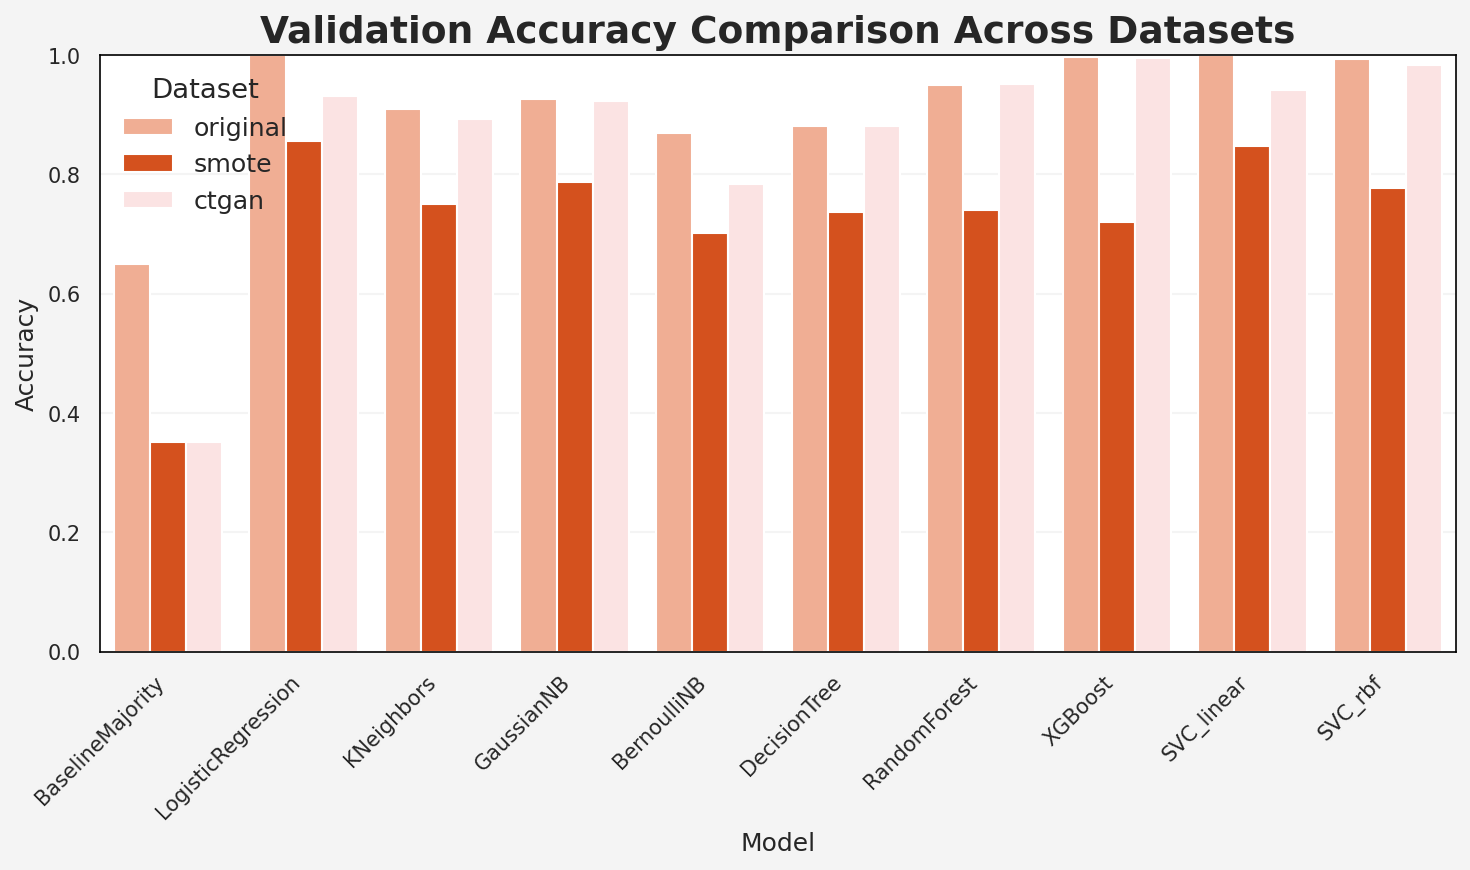

已儲存 Accuracy 比較圖：accuracy_comparison.png


In [ ]:
print("\n--- Step 7.8: Accuracy Bar Chart ---")

# 先 pivot 至 long format
df_acc = df_all_results[['Model', 'Dataset', 'Val_Accuracy']]

# 畫圖
plt.figure(figsize=(10, 6), facecolor="#f4f4f4")
sns.barplot(data=df_acc, x='Model', y='Val_Accuracy', hue='Dataset', palette=['#ffa785', '#f24300', '#ffdfdf'])#'orig_min': '#7ed957', 'smote_min': '#ff5757', 'ctgan_min': '#0ccdf0'

plt.title("Validation Accuracy Comparison Across Datasets")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(frameon=False, title="Dataset")
plt.grid(axis='y', color='#f4f4f4')
plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

print("已儲存 Accuracy 比較圖：accuracy_comparison.png")
